# Tumor/Normal classification from Single-Cell gene expression data

In [1]:
import pandas as pd
from collections import Counter
import numpy as np
import scanpy as sc

from matplotlib import pyplot

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

/Users/giovannanicora/.conda/envs/untitled/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
dir_anno = '/Users/giovannanicora/Documents/single-cell_hierarchies/per_amia/GSE116256_RAW/anno_files/'
path_anno = dir_anno+'GSM3587943_AML329-D20.anno.txt.gz'
anno = pd.read_csv(path_anno, sep='\t')

In [3]:
anno.columns
print(Counter(anno.PredictionRefined))
print(Counter(anno.CellType))

Counter({'normal': 694, 'malignant': 259})
Counter({'Mono': 336, 'Prog-like': 108, 'T': 86, 'cDC': 81, 'cDC-like': 74, 'ProMono': 51, 'GMP-like': 39, 'CTL': 33, 'NK': 30, 'B': 25, 'Prog': 19, 'Mono-like': 17, 'GMP': 12, 'ProMono-like': 11, 'HSC-like': 10, 'lateEry': 9, 'HSC': 6, 'earlyEry': 4, 'Plasma': 1, 'pDC': 1})


In [4]:
# Myeloid cells
mcells = ['HSC', 'Prog', 'GMP', 'Promono', 'Mono', 'cDC', 'pDC']

# Selecting only myeloid cells (normal or tumor)
ind_myeloid_malign = [i for i,x in enumerate(anno.CellType) if 'like' in x]
ind_myeloid_benign = [i for i,x in enumerate(anno.CellType) if x in mcells]

In [5]:
len(ind_myeloid_benign)

455

In [6]:
len(ind_myeloid_malign)

259

In [7]:
ge_files = '/Users/giovannanicora/Documents/single-cell_hierarchies/per_amia/GSE116256_RAW/ge_files/'
df = pd.read_csv(ge_files+'GSM3587942_AML329-D20.dem.txt.gz',
                 sep='\t')

In [8]:
df.shape

(27899, 954)

In [9]:
#df.head()
gene_names = df['Gene']
# Selecting only Myeloid
barcodes_myeloid = list(anno.Cell[ind_myeloid_malign])+list(anno.Cell[ind_myeloid_benign])
m_col = [i for i,x in enumerate(df.columns) if x in barcodes_myeloid]
df = df.iloc[:, m_col]
df.shape

(27899, 714)

In [10]:
barcodes = [x for x in df.columns if 'Gene' not in x]
anndata = sc.AnnData(X=df.T.to_numpy(), obs=barcodes, var=gene_names.values)

In [11]:
anndata.var_names = gene_names.values

In [12]:
anndata.obs_names = barcodes

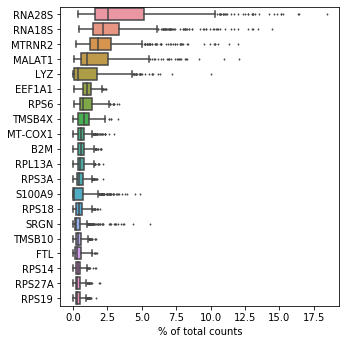

In [13]:
anndata.raw = anndata
sc.pl.highest_expr_genes(anndata, n_top=20, )

In [14]:
anndata.shape


(714, 27899)

In [15]:
# Normalization and filtering
sc.pp.filter_genes(anndata, min_cells=50)

In [16]:
anndata.shape

(714, 4995)

In [17]:
sc.pp.normalize_total(anndata, target_sum=1e4)
sc.pp.log1p(anndata)

In [18]:
np.max(anndata.raw.X)
np.max(anndata.X)

7.583314

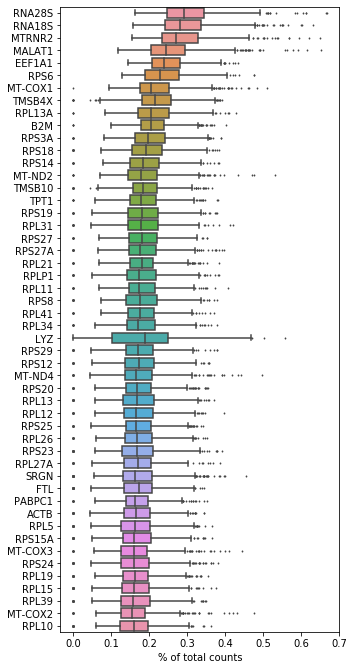

In [19]:
sc.pl.highest_expr_genes(anndata, n_top=50, )

## Machine Learning

In [20]:
barcodes2class = dict(zip(anno.Cell,
                          anno.PredictionRefined))
y_true = [barcodes2class[x] for x in anndata.obs_names]
X = anndata.X
X_train = X
classdict = dict(normal=0, malignant=1)
y_true_num = [classdict[x] for x in y_true]
y_train = np.array(y_true_num)

POP on training set

In [21]:
# POP on the training set
from pop_implemetation import *

(mind_train, maxd_train, isborder_train, attr2outerb_train, attr2innerb_train,
 attr2outerb_train_val, attr2innerb_train_val) = pop_instance_training(X_train, y_train)
train_border_examples = X_train[np.argwhere(np.sum(np.abs(isborder_train), axis=1)!=0).ravel(),:]
ytrain_border_examples = y_train[np.argwhere(np.sum(np.abs(isborder_train), axis=1)!=0).ravel()]


In [22]:

clf_lr = LogisticRegression(penalty='l1', solver='liblinear')  # Lasso
scores_lr= cross_validate(clf_lr, X_train, 
                        y_train, cv=5,
                        scoring={'accuracy_score':make_scorer(accuracy_score),
                                 'precision_score':make_scorer(precision_score),
                                 'prc':make_scorer(average_precision_score),
                                 'mcc':make_scorer(matthews_corrcoef)})

                                

In [23]:
# Training on the entire training set
clf_lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
scores_lr

{'fit_time': array([0.13366795, 0.07467079, 0.11204028, 0.16087317, 0.10870695]),
 'score_time': array([0.04089403, 0.00598907, 0.07925773, 0.01687479, 0.006073  ]),
 'test_accuracy_score': array([0.9020979 , 0.84615385, 0.88111888, 0.83916084, 0.85211268]),
 'test_precision_score': array([0.82758621, 0.77777778, 0.87234043, 0.76363636, 0.77777778]),
 'test_prc': array([0.79189776, 0.6981352 , 0.76472995, 0.68671329, 0.70390316]),
 'test_mcc': array([0.79668976, 0.67060102, 0.73993264, 0.65737574, 0.68353543])}

In [25]:
mean_cv = [x+':'+str(np.mean(scores_lr[x])) for x in scores_lr.keys() ]
std_cv = [x+':'+str(np.std(scores_lr[x])) for x in scores_lr.keys() ]

In [26]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_lr['test_accuracy_score'].mean(), scores_lr['test_accuracy_score'].std() * 2))
print("Precision: %0.2f (+/- %0.2f)" % (scores_lr['test_precision_score'].mean(), scores_lr['test_precision_score'].std() * 2))

print("MCC: %0.2f (+/- %0.2f)" % (scores_lr['test_mcc'].mean(), scores_lr['test_mcc'].std() * 2))

Accuracy: 0.86 (+/- 0.05)
Precision: 0.80 (+/- 0.08)
MCC: 0.71 (+/- 0.10)


In [27]:
scores_lr.keys()

dict_keys(['fit_time', 'score_time', 'test_accuracy_score', 'test_precision_score', 'test_prc', 'test_mcc'])

### Predicting on a Validation dataset
We try to predict the class of new unseen examples from different patients

In [28]:
path_anno = dir_anno+'GSM3587932_AML328-D0.anno.txt.gz'
anno329d0 = pd.read_csv(path_anno, sep='\t')
anno329d37 = pd.read_csv(dir_anno+'GSM3587945_AML329-D37.anno.txt.gz',
                         sep='\t')


# Selecting only myeloid cells (normal or tumor)
ind_myeloid_malign_d0 = [i for i, x in enumerate(anno329d0.CellType) if 'like' in x]
ind_myeloid_benign_d0 = [i for i, x in enumerate(anno329d0.CellType) if x in mcells]
ind_myeloid_malign_d37 = [i for i, x in enumerate(anno329d37.CellType) if 'like' in x]
ind_myeloid_benign_d37 = [i for i, x in enumerate(anno329d37.CellType) if x in mcells]

In [29]:
df_d0 = pd.read_csv(ge_files+'GSM3587931_AML328-D0.dem.txt.gz',
                 sep='\t')
df_d37 = pd.read_csv(ge_files+'GSM3587944_AML329-D37.dem.txt.gz',
                 sep='\t')
iGenes_d0 = [i for i, x in enumerate(df_d0['Gene']) if x in anndata.var_names]
iGenes_d37 = [i for i, x in enumerate(df_d37['Gene']) if x in anndata.var_names]

gene_names_d0 = df_d0['Gene']
gene_names_d37 = df_d37['Gene']

In [30]:
# Selecting only Myeloid
barcodes_myeloid_d0 = list(anno329d0.Cell[ind_myeloid_malign_d0]) + list(anno329d0.Cell[ind_myeloid_benign_d0])
barcodes_myeloid_d37 = list(anno329d37.Cell[ind_myeloid_malign_d37]) + list(anno329d37.Cell[ind_myeloid_benign_d37])

m_col_d0 = [i for i, x in enumerate(df_d0.columns) if x in barcodes_myeloid_d0]
m_col_d37 = [i for i, x in enumerate(df_d37.columns) if x in barcodes_myeloid_d37]

df_d37 = df_d37.iloc[iGenes_d37, m_col_d37]
df_d0 = df_d0.iloc[iGenes_d0, m_col_d0]


barcodes_d0 = [x for x in df_d0.columns if 'Gene' not in x]
barcodes_d37 = [x for x in df_d37.columns if 'Gene' not in x]

df = pd.concat((df_d0, df_d37),axis=1, ignore_index=True)

barcodes = barcodes_d0+barcodes_d37
anndata_val = sc.AnnData(X=df.T.to_numpy(), obs=barcodes, var=anndata.var_names)

anndata_val.var_names = anndata.var_names

anndata_val.obs_names = barcodes

In [31]:
anndata_val.shape

(946, 4995)

In [32]:
# Normalization per cell
sc.pp.normalize_total(anndata_val)
sc.pp.log1p(anndata_val)

In [33]:

barcodes2class = dict(zip(pd.concat((anno329d0.Cell, anno329d37.Cell)),
                          pd.concat((anno329d0.PredictionRefined, anno329d37.PredictionRefined))))



y_true_val = [barcodes2class[x] for x in anndata_val.obs_names]

X_val = anndata_val.X
y_true_val_num = [classdict[x] for x in y_true_val]
y_val = np.array(y_true_val_num)

In [34]:
vald = Counter(y_val)
vald

Counter({1: 709, 0: 237})

In [35]:
ypred_val_lr = clf_lr.predict(X_val)

acc_val_lr = accuracy_score(y_val, ypred_val_lr)

prec_val_lr = precision_score(y_val, ypred_val_lr)  # Precision decrease a lot! (form 86% to 56%)

rec_val_lr = recall_score(y_val, ypred_val_lr)

mcc_val_lr = matthews_corrcoef(y_val, ypred_val_lr)

tn_val_lr, fp_val_lr, fn_val_lr, tp_val_lr = confusion_matrix(y_val, ypred_val_lr).ravel()

In [36]:
print('Accuracy on validation:'+str(acc_val_lr))
print('Precision on validation:'+str(prec_val_lr))
print('Recall on validation:'+str(rec_val_lr))
print('MCC on validation:'+str(mcc_val_lr))
spec_lr = tn_val_lr / (tn_val_lr + fp_val_lr)
print('Specificity on validation:'+str(spec_lr))

Accuracy on validation:0.6374207188160677
Precision on validation:0.8796680497925311
Recall on validation:0.5980253878702397
MCC on validation:0.3062372299632623
Specificity on validation:0.7552742616033755


In [53]:
## Reliability on Validation set
n_border_val = [0] * X_val.shape[0]
is_border_val = np.zeros(X_val.shape)
for c in list(range(X_val.shape[0])):
    # print(c)
    xval = X_val[c]
    bor = ''
    for i in range(X_val.shape[1]):
        bor = bor + check_is_border(xval[i], attr2outerb_train_val[i], inner=False)
        bor = bor + check_is_border(xval[i], attr2innerb_train_val[i], inner=True)
        if 'Outer' in bor or 'Inner' in bor:
            n_border_val[c] = n_border_val[c] + 1
            is_border_val[c, i] = 1
            
            

In [38]:
rel_val = 1 - np.array(n_border_val) / X_val.shape[1]
unreliable_val = np.argwhere(rel_val == 0).ravel()
reliable_val = np.argwhere(rel_val > 0).ravel()  # or !=0

In [39]:
len(np.unique(rel_val))

4

In [40]:
acc_unrel_val_lr = accuracy_score(y_val[unreliable_val], ypred_val_lr[unreliable_val])
prec_unrel_val_lr = precision_score(y_val[unreliable_val], ypred_val_lr[unreliable_val])
mcc_unrel_val_lr = matthews_corrcoef(y_val[unreliable_val], ypred_val_lr[unreliable_val])

acc_rel_val_lr = accuracy_score(y_val[reliable_val], ypred_val_lr[reliable_val])
prec_rel_val_lr = precision_score(y_val[reliable_val], ypred_val_lr[reliable_val])
mcc_rel_val_lr = matthews_corrcoef(y_val[reliable_val], ypred_val_lr[reliable_val])

acc_val_lr = accuracy_score(y_val, ypred_val_lr)
prec_val_lr = precision_score(y_val, ypred_val_lr)
mcc_val_lr = matthews_corrcoef(y_val, ypred_val_lr)

tn_val_lr_rel, fp_val_lr_rel, fn_val_lr_rel, tp_val_lr_rel = confusion_matrix(y_val[reliable_val], 
                                                                                  ypred_val_lr[reliable_val]).ravel()
tn_val_lr_unrel, fp_val_lr_unrel, fn_val_lr_unrel, tp_val_lr_unrel = confusion_matrix(y_val[unreliable_val], 
                                                                                  ypred_val_lr[unreliable_val]).ravel()
spec_rel_val = tn_val_lr_rel/(tn_val_lr_rel+fp_val_lr_rel)
spec_unrel_val = tn_val_lr_unrel/(tn_val_lr_unrel+fp_val_lr_unrel)


sens_rel_val = tp_val_lr_rel/(tp_val_lr_rel+fn_val_lr_rel)
sens_unrel_val = tp_val_lr_unrel/(tp_val_lr_unrel+fn_val_lr_unrel)
sens_val = tp_val_lr/(tp_val_lr+fn_val_lr)

In [41]:
print('Number of elements in validation:' + str(X_val.shape[0]))
print('Number of reliable examples in validation:' + str(len(reliable_val)))
print('Number of unreliable examples in validation:' + str(len(unreliable_val)))

Number of elements in validation:946
Number of reliable examples in validation:109
Number of unreliable examples in validation:837


In [42]:
print('Accuracy on validation:' + str(acc_val_lr))
print('Accuracy on reliable validation:' + str(acc_rel_val_lr))
print('Accuracy on unreliable validation:' + str(acc_unrel_val_lr))

print('Precision on validation:' + str(prec_val_lr))
print('Precision on reliable validation:' + str(prec_rel_val_lr))
print('Precision on unreliable validation:' + str(prec_unrel_val_lr))


print('MCC on validation:' + str(mcc_val_lr))
print('MCC on reliable validation:' + str(mcc_rel_val_lr))
print('MCC on unreliable validation:' + str(mcc_unrel_val_lr))

print('Sensitivity on validation: '+str(sens_val))
print('Sensitivity on reliable validation: '+str(sens_rel_val))
print('Sensitivity on unreliable validation: '+str(sens_unrel_val))

Accuracy on validation:0.6374207188160677
Accuracy on reliable validation:0.7614678899082569
Accuracy on unreliable validation:0.6212664277180406
Precision on validation:0.8796680497925311
Precision on reliable validation:0.9714285714285714
Precision on unreliable validation:0.8640776699029126
MCC on validation:0.3062372299632623
MCC on reliable validation:0.47039919195511365
MCC on unreliable validation:0.2838962829162476
Sensitivity on validation: 0.5980253878702397
Sensitivity on reliable validation: 0.7391304347826086
Sensitivity on unreliable validation: 0.5769854132901134


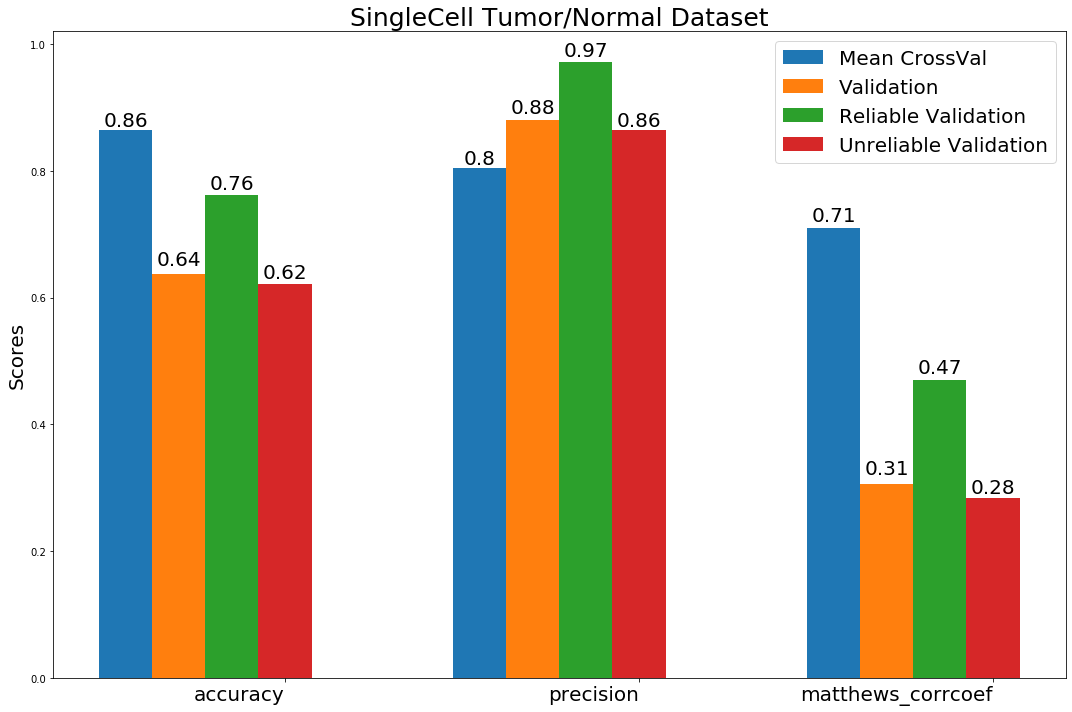

In [43]:
labels = ['accuracy', 'precision',
          'matthews_corrcoef']

r1 = np.arange(len(labels))  # the label locations

width = 0.15  # the width of the bars
# Set position of bar on X axis
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]
r4 = [x + width for x in r3]

f=20
fig, ax = pyplot.subplots(figsize=(15,10))
rects1 = ax.bar(r1, [scores_lr['test_accuracy_score'].mean(), 
                     scores_lr['test_precision_score'].mean(),
                     scores_lr['test_mcc'].mean()], width, label='Mean CrossVal')
rects2 = ax.bar(r2, [acc_val_lr, prec_val_lr, mcc_val_lr], width, label='Validation')
rects3 = ax.bar(r3, [acc_rel_val_lr, prec_rel_val_lr, mcc_rel_val_lr], width, label='Reliable Validation')
rects4 = ax.bar(r4, [acc_unrel_val_lr, prec_unrel_val_lr, mcc_unrel_val_lr], width, label='Unreliable Validation')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores', fontsize=f)
ax.set_title('SingleCell Tumor/Normal Dataset', fontsize=25)
ax.set_xticks(r4)
ax.set_xticklabels(labels, ha="right", fontsize=f)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(), 2)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=f)


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
pyplot.legend(prop={'size': f})
fig.tight_layout()
pyplot.savefig('/Users/giovannanicora/Desktop/results_singlecell.png')
pyplot.show()



In [44]:
z = 1.96
interval = z * np.sqrt(mcc_val_lr * (1 - mcc_val_lr) / X_val.shape[0])
conf_inf = [mcc_val_lr - interval, mcc_val_lr + interval]
print('Confidence intervals for MCC on Validation:' + str(conf_inf[0]) + '-' + str(conf_inf[1]))

Confidence intervals for MCC on Validation:0.2768644540429343-0.3356100058835903


In [45]:
z = 1.96
interval = z * np.sqrt(prec_val_lr * (1 - prec_val_lr) / X_val.shape[0])
conf_inf = [prec_val_lr - interval, prec_val_lr + interval]
print('Confidence intervals for Precision on Validation:' + str(conf_inf[0]) + '-' + str(conf_inf[1]))

Confidence intervals for Precision on Validation:0.8589351337037914-0.9004009658812708


In [46]:
z = 1.96
interval = z * np.sqrt(sens_val * (1 - sens_val) / X_val.shape[0])
conf_inf = [sens_val - interval, sens_val + interval]
print('Confidence intervals for Sensitivity on Validation:' + str(conf_inf[0]) + '-' + str(conf_inf[1]))

Confidence intervals for Sensitivity on Validation:0.5667811722493793-0.6292696034911002


Correct and uncorrect examples in reliable and unreliable dataset

In [47]:
correct_val = (y_val == ypred_val_lr).astype(int)
correct_val_rel = (y_val[reliable_val] == ypred_val_lr[reliable_val]).astype(int)
correct_val_unrel = (y_val[unreliable_val] == ypred_val_lr[unreliable_val]).astype(int)

n_correct_val = len(np.where(correct_val==1)[0])
n_uncorrect_val = len(np.where(correct_val==0)[0])

n_correct_val_rel = len(np.where(correct_val_rel==1)[0])
n_uncorrect_val_rel = len(np.where(correct_val_rel==0)[0])

n_correct_val_unrel = len(np.where(correct_val_unrel==1)[0])
n_uncorrect_val_unrel = len(np.where(correct_val_unrel==0)[0])

df_c = pd.DataFrame(dict(Val_Tot=[n_correct_val, n_uncorrect_val], 
                         Val_Rel=[n_correct_val_rel, n_uncorrect_val_rel],
                         Val_Unrel=[n_correct_val_unrel, n_uncorrect_val_unrel]
                        ), index=['correct', 'not_correct'])
df_c

,Val_Tot,Val_Rel,Val_Unrel
correct,603,83,520
not_correct,343,26,317


In [48]:
df_c_p = pd.DataFrame(dict(Val_Tot=[n_correct_val/len(y_val), n_uncorrect_val/len(y_val)],
                         Val_Rel=[n_correct_val_rel/len(reliable_val), n_uncorrect_val_rel/len(reliable_val)],
                         Val_Unrel=[n_correct_val_unrel/len(unreliable_val), n_uncorrect_val_unrel/len(unreliable_val)]), 
                           
                        index=['perc_correct', 'perc_not_correct'])
df_c_p

,Val_Tot,Val_Rel,Val_Unrel
perc_correct,0.637421,0.761468,0.621266
perc_not_correct,0.362579,0.238532,0.378734


In [49]:
coef = clf_lr.coef_[0]
iC = np.where(coef!=0)[0]
feat = np.array(anndata.var_names)

In [51]:
coef_feat = pd.DataFrame(dict(f=feat[iC], 
                  coef=coef[iC]), 
                   index=feat[iC])

In [52]:
coef_feat

,f,coef
ACAP2,ACAP2,0.097721
ACBD3,ACBD3,0.151804
ACIN1,ACIN1,0.178736
ADAR,ADAR,0.278078
AKR1A1,AKR1A1,0.386175
...,...,...
YWHAQ,YWHAQ,0.141462
ZC3H15,ZC3H15,-0.051798
ZEB2,ZEB2,-0.010377
ZFAND5,ZFAND5,-0.031533


In [ ]:
unreliable_val_borders = is_border_val[unreliable_val]